# Supervised Machine Learning - Classification

This is the final assessment project for course 3 of [IBM Machine Learning Specialization](https://www.coursera.org/specializations/ibm-machine-learning).

# About the data

We'll be working with [Obesity](https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition)
dataset provided by [UCI Machine Learning Repository](https://archive.ics.uci.edu/). This dataset includes data for the estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia.

Using an online survey, data has been collected regarding each participant's eating and drinking habits, as well as their overall lifestyle. Based on the answers, an obesity level was estimated for each person.

## Features

- Gender : (Male/Female)
- Age : Person's age
- Height : Person's height, in meters
- Weight : Person's weight, in kilograms
- family_history_with_overweight : Has a family member suffered or suffers from overweight? (yes/no)
- FAVC : Do you eat high caloric food frequently? (yes/no)
- FCVC : Do you usually eat vegetables in your meals? (numeric)
- NCP : How many main meals do you have daily? (numeric)
- CAEC : Do you eat any food between meals? (ordinal)
- SMOKE : Do you smoke? (yes/no)
- CH2O : How much water do you drink daily? (numeric)
- SCC : Do you monitor the calories you eat daily? (yes/no)
- FAF : How often do you have physical activity? (numeric)
- TUE : How much time do you use technological devices such as cell phone, videogames, television, computer and others? (numeric)
- CALC : How often do you drink alcohol? (ordinal)
- MTRANS : Which transportation do you usually use? (nominal)
- NObeyesdad : Obesity level (target class)

# Objectives

Having more than 2 class labels, this dataset requires multi-class classification to predict one of the following obesity levels :

- Insufficient Weight
- Normal Weight
- Overweight Level I
- Overweight Level II
- Obesity Type I
- Obesity Type II
- Obesity Type III

The objectives for this project can be summarized as follows :

- Using dataset features to predict obesity level for a new person. This can be helpful as some kind of preliminary medical assessment.
- Using model interpretation techniques to gain insights about most important features that may help avoiding overweight/obesity disorders.
- Building a model with a minimum baseline performance : Accuracy score >= 97%, F1 score >= 90%

## Environment setup

In this project, we'll be using Numpy, Pandas, Matplotlib, Seaborn and Scikit-Learn, all of which should normally be installed
in any Python Machine Learning environment.

Please run the following cells to prepare our modeling environment.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

%matplotlib inline

In [2]:
# Use a random state for repeatability
rs = 14741

# Load Obesity dataset from current directory into a Pandas DataFrame
df = pd.read_csv('obesity.csv')

# Exploratory Data Analysis (EDA)

To get familiar with important dataset characteristics, an exhaustive data analysis was made before preparing dataset for modeling. The following sections briefly summarize the results of this analysis.

## Initial data exploration

Preliminary examination of the dataset revealed the following characteristics :

- Dataset has 2111 instances, so it is rather small and using all instances in a 70/30 or 80/20 split will not slow down most learning algorithms.
- Dataset has 16 features, half numerical and half categorical.
- Dataset has all kinds of categorical features, namely: binary (yes/no), ordinal and nominal.
- Dataset has no missing values in any features, so no data imputing will be required later.
- Summary statistics of numeric features shows different value ranges, meaning we should probably scale them to improve performance and stability of linear (e.g., Logistic Regression) and distance-based (e.g., KNN and Linear SVC) models.

Please run the following cells for a demonstration of these characteristics.

In [3]:
# Preview a random sample of instances
df.sample(5, random_state=rs)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
206,Male,19.00000,1.750000,100.000000,yes,yes,2.000000,3.0,Frequently,no,2.000000,no,2.000000,0.000000,no,Public_Transportation,Obesity_Type_I
658,Female,19.59904,1.566501,41.706283,no,yes,2.967853,1.0,Frequently,no,1.131185,no,0.000000,0.504176,Sometimes,Public_Transportation,Insufficient_Weight
533,Male,23.00000,1.835643,58.854416,yes,yes,3.000000,3.0,Sometimes,no,2.027984,no,1.661556,0.114716,Sometimes,Automobile,Insufficient_Weight
290,Male,16.00000,1.820000,71.000000,yes,yes,2.000000,3.0,Frequently,no,2.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Normal_Weight
102,Female,21.00000,1.550000,57.000000,no,yes,2.000000,4.0,Frequently,no,2.000000,yes,2.000000,0.000000,Sometimes,Automobile,Normal_Weight


In [4]:
# Check out dataset shape
df.shape

(2111, 17)

In [5]:
# Get a brief overview of data types
df.dtypes.value_counts()

object     9
float64    8
Name: count, dtype: int64

In [6]:
# Get an initial feeling of how much feature engineering we need later
df.select_dtypes(['object']).nunique()

Gender                            2
family_history_with_overweight    2
FAVC                              2
CAEC                              4
SMOKE                             2
SCC                               2
CALC                              4
MTRANS                            5
NObeyesdad                        7
dtype: int64

In [7]:
# Check out unique values in non-binary categorical features
print(f'Unique values in CAEC feature :\t\t{list(df['CAEC'].unique())}')
print(f'Unique values in CALC feature :\t\t{list(df['CALC'].unique())}')
print(f'Unique values in MTRANS feature :\t{list(df['MTRANS'].unique())}')

Unique values in CAEC feature :		['Sometimes', 'Frequently', 'Always', 'no']
Unique values in CALC feature :		['no', 'Sometimes', 'Frequently', 'Always']
Unique values in MTRANS feature :	['Public_Transportation', 'Walking', 'Automobile', 'Motorbike', 'Bike']


## Class balance analysis

Description provided by the dataset donor states that this dataset includes both real and synthetic data, meaning class labels in original data has been explicitly balanced using a specific form of SMOTE resampling.

Please run the following cells to see the breakdown of class labels in dataset.

In [8]:
# Breakdown of class labels (count)
df['NObeyesdad'].value_counts()

NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64

In [9]:
# Breakdown of class labels (proportion)
df['NObeyesdad'].value_counts(normalize=True)

NObeyesdad
Obesity_Type_I         0.166272
Obesity_Type_III       0.153482
Obesity_Type_II        0.140692
Overweight_Level_I     0.137376
Overweight_Level_II    0.137376
Normal_Weight          0.135955
Insufficient_Weight    0.128849
Name: proportion, dtype: float64

<Axes: xlabel='NObeyesdad'>

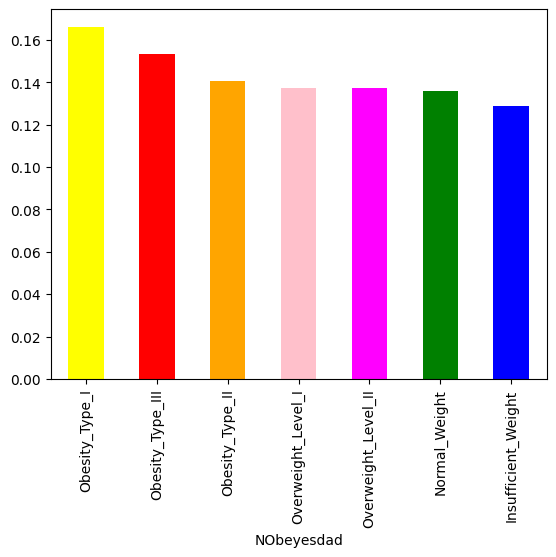

In [10]:
# Visualization of class label balance in a bar plot
df['NObeyesdad'].value_counts(normalize=True).plot.bar(
    color=['yellow', 'red', 'orange', 'pink', 'magenta', 'green', 'blue'])

## Correlation analysis

Correlation analysis using numeric features revealed that no significant correlation exists between these features. The highest positive correlation value (0.46) exists between Height and Weight, which seems almost natural except in the most extreme cases (e.g. a very tall underweight or a very short overweight person).

Please run the following cells to see the results of correlation analysis.

In [11]:
corr_df = df.corr(numeric_only=True)
corr_df

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
Age,1.000000,-0.025958,0.202560,0.016291,-0.043944,-0.045304,-0.144938,-0.296931
Height,-0.025958,1.000000,0.463136,-0.038121,0.243672,0.213376,0.294709,0.051912
Weight,0.202560,0.463136,1.000000,0.216125,0.107469,0.200575,-0.051436,-0.071561
FCVC,0.016291,-0.038121,0.216125,1.000000,0.042216,0.068461,0.019939,-0.101135
NCP,-0.043944,0.243672,0.107469,0.042216,1.000000,0.057088,0.129504,0.036326
CH2O,-0.045304,0.213376,0.200575,0.068461,0.057088,1.000000,0.167236,0.011965
FAF,-0.144938,0.294709,-0.051436,0.019939,0.129504,0.167236,1.000000,0.058562
TUE,-0.296931,0.051912,-0.071561,-0.101135,0.036326,0.011965,0.058562,1.000000


In [12]:
# Disable self correlations for the upcoming examination
for col in corr_df.columns:
    corr_df.loc[col,col] = 0.0

# Build a DataFrame from the highest pair-wise correlations
corr_maps = []
indices = np.argmax(corr_df.abs(), axis=1)
for i in range(len(indices)):
    corr_map = pd.Series({'Corr_Col': str(corr_df.columns[indices[i]]), 'Corr_Val': float(corr_df.iloc[i, indices[i]])})
    corr_maps.append(corr_map)

high_corr_df = pd.DataFrame(pd.concat(corr_maps, axis=1).T)
high_corr_df.index = list(corr_df.columns)
high_corr_df

,Corr_Col,Corr_Val
Age,TUE,-0.296931
Height,Weight,0.463136
Weight,Height,0.463136
FCVC,Weight,0.216125
NCP,Height,0.243672
CH2O,Height,0.213376
FAF,Height,0.294709
TUE,Age,-0.296931


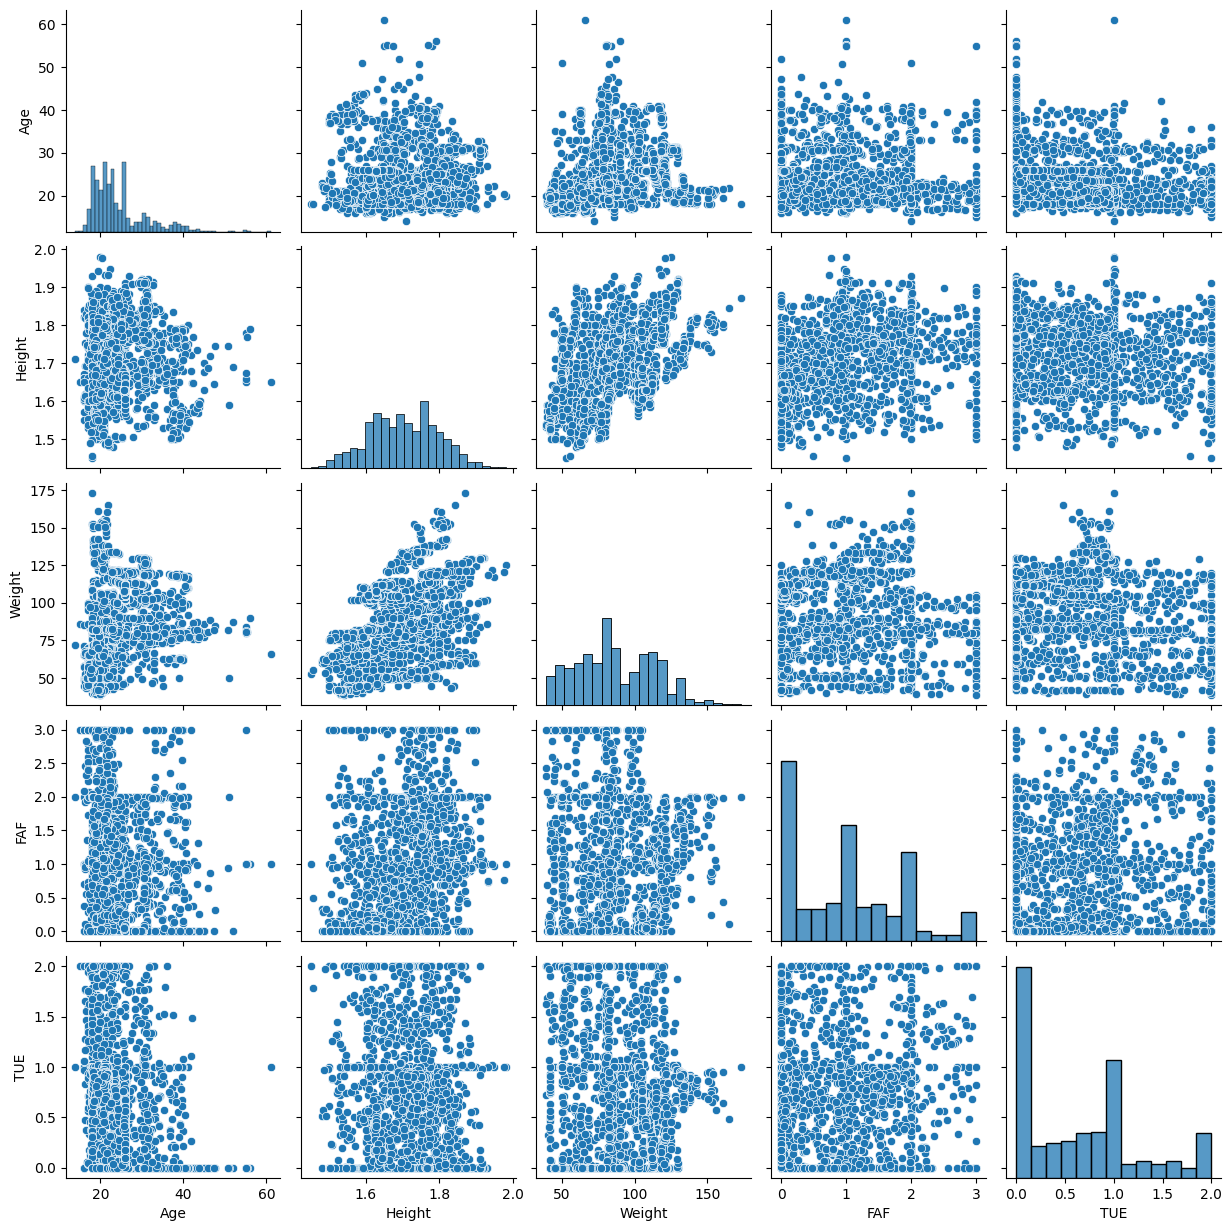

In [13]:
# Visualize highest correlation values in a partial pair plot
sns.pairplot(df[['Age', 'Height', 'Weight', 'FAF', 'TUE']])

## Normality analysis

Distribution of most numeric features is fairly close to a normal distribution. Only two features (Age and NCP) have significant skewness (i.e., skew > 0.75). To improve performance of linear models like logistic regression, we may later consider transforming numeric features using a suitable transform (Log, Square Root or BoxCox).

Please run the following cells to examine the most skewed features.

In [14]:
# Find a list of all features that have significant skewness (> 0.75)
skew_vals = df.select_dtypes(['float64']).skew()
skew_cols = skew_vals[abs(skew_vals) > 0.75]
skew_cols

Age    1.529100
NCP   -1.107097
dtype: float64

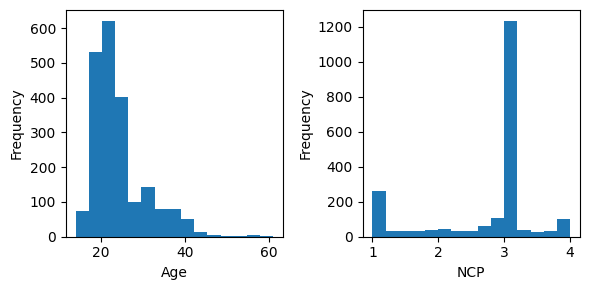

In [15]:
# Visualize the most skewed features in histograms
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].hist(df['Age'], bins=15)
axes[0].set(xlabel='Age', ylabel='Frequency')

axes[1].hist(df['NCP'], bins=15)
axes[1].set(xlabel='NCP', ylabel='Frequency')

plt.tight_layout()
plt.show()

# Feature selection and engineering

Obesity dataset has different types of categorical features. The following steps summarize the feature selection/engineering approaches used for each.

### Feature selection

The MTRANS (means of transportation) feature was removed, for two reasons :

- It doesn't seem to have useful information (other than Walking, the other values don't seem to contribute much to weight control)
- Values don't imply any order and must be one-hot encoded, which adds several correlated features.

### Feature engineering

- As a convenience, two features were renamed ('family_history_with_overweight' renamed to 'fam_history' and 'NObeyesdad' renamed to 'Obesity')
- All binary features (Gender, FAVC, SMOKE, etc.) were encoded using LabelEncoder with values of 0 and 1.
- Ordinal features (CAEC and CALC) were encoded with a custom mapping, using the obvious ordering implied by values : no (0), Sometimes (1), Frequently (2), Always (3)
- Class labels were encoded using LabelEncoder with values from 0 to 6 (for 7 class labels)
- Whenever required by a model, all features were scaled using MinMaxScaler.

Please run the following cells to see how the above encodings were done in code.

In [16]:
# Make a copy of original data for later verification of encodings
data = df.copy()

data = data.drop(['MTRANS'], axis=1)

# Rename selected feature names as a convenience
data.columns = pd.Index([col.replace('family_history_with_overweight', 'fam_history')
                     .replace('NObeyesdad', 'Obesity') for col in data.columns])
data.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'fam_history', 'FAVC', 'FCVC',
       'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'Obesity'],
      dtype='object')

In [17]:
# Setup binary encoders with predefined values
le_bin = LabelEncoder().fit(['no', 'yes'])
le_gen = LabelEncoder().fit(['Female', 'Male'])

# Setup a custom mapping for ordinal features
freq_map = {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}

# Fit a label encoder to class labels
le_class = LabelEncoder().fit(data['Obesity'])

In [18]:
# Check encoded labels
le_class.classes_

array(['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I',
       'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I',
       'Overweight_Level_II'], dtype=object)

In [19]:
# Encode categorical features using previously fit encoders and our custom mapping
bin_cols = ['fam_history', 'FAVC', 'SMOKE', 'SCC']
ord_cols = ['CAEC', 'CALC']

data.Gender = le_gen.transform(data.Gender)

for col in bin_cols:
    data[col] = le_bin.transform(data[col])

for col in ord_cols:
    data[col] = data[col].map(freq_map)

# Encode class labels
data['Obesity'] = le_class.transform(data['Obesity'])

In [20]:
# Check out top instances in our fully processed dataset
data.head()

,Gender,Age,Height,Weight,fam_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,Obesity
0,0,21.0,1.62,64.0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,1
1,0,21.0,1.52,56.0,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,1
2,1,23.0,1.80,77.0,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,2,1
3,1,27.0,1.80,87.0,0,0,3.0,3.0,1,0,2.0,0,2.0,0.0,2,5
4,1,22.0,1.78,89.8,0,0,2.0,1.0,1,0,2.0,0,0.0,0.0,1,6


In [21]:
# Check out the same top instances to verify encodings
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


# Classification models

To reach the objectives of this project, several models were trained. The whole modeling process can be summarized in the following stages :

- Train/Test split : The whole dataset was split into 70% train and 30% test sets, using stratification to maintain class balance.
- Logistic regression : A pipeline was used to scale data before fitting the model. To avoid complications with l1_ratio parameter (used by ElasticNet regularization), 3 regularization modes (None, L1 and L2) were used while tuning the model with GridSearch.
- Logistic regression : A separate model was trained with ElasticNet and was tuned using different L1/L2 ratios.
- Support Vector Machines (SVM) : A pipeline was used to scale data before fitting the model. The model was tuned using different values for 'C' and 'kernel' hyperparameters.
- Decision Tree : Trained and tuned a model using 'criterion', 'max_depth' and 'min_samples_leaf' hyperparameters. To achieve better interpretability, limited 'max_depth' values to 5.
- Random Forest : Trained and tuned a model using 'n_estimators', 'criterion', 'max_depth' and 'max_features' hyperparameters. To achieve better interpretability, limited 'max_depth' values to 4.
- Gradient Boosting : Trained and tuned a model using 'n_estimators', 'criterion', 'learning_rate' and 'max_features' hyperparameters.
- Aggregated performance metrics of each (best) model for easier comparison.

Please run the following cells to see the results obtained from different models.

## Data preparation

In [22]:
X = data.iloc[:, :-1]
y = data['Obesity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=rs)

print(f'Training dataset shape, X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Testing dataset shape,  X_test:  {X_test.shape},  y_test:  {y_test.shape}')

Training dataset shape, X_train: (1477, 15), y_train: (1477,)
Testing dataset shape,  X_test:  (634, 15),  y_test:  (634,)


In [23]:
def get_accuracy_f1_scores(model, X_trn, y_trn, X_tst, y_tst, model_name):
    y_pred_trn = model.predict(X_trn)
    y_pred_tst = model.predict(X_tst)
    scores = pd.Series({'model': model_name,
                        'train accuracy': accuracy_score(y_trn, y_pred_trn),
                        'test accuracy' : accuracy_score(y_tst, y_pred_tst),
                        'train f1 score': f1_score(y_trn, y_pred_trn, average='weighted'),
                        'test f1 score' : f1_score(y_tst, y_pred_tst, average='weighted')})
    return scores

In [24]:
all_scores = []

## Logistic Regression

In [25]:
pipe = [('minmax', MinMaxScaler()), ('model', LogisticRegression(solver='saga', max_iter=5000, random_state=rs))]
pipeline = Pipeline(pipe)

param_grid = {'model__penalty': [None, 'l1', 'l2'],
             'model__C': [1.0, 5.0, 10.0]}
search_lr = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=2, cv=5)
search_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmax', MinMaxScaler()),
                                       ('model',
                                        LogisticRegression(max_iter=5000,
                                                           random_state=14741,
                                                           solver='saga'))]),
             n_jobs=2,
             param_grid={'model__C': [1.0, 5.0, 10.0],
                         'model__penalty': [None, 'l1', 'l2']})

In [26]:
search_lr.best_params_

{'model__C': 1.0, 'model__penalty': None}

In [27]:
best_lr = search_lr.best_estimator_
all_scores.append(get_accuracy_f1_scores(best_lr, X_train, y_train, X_test, y_test, 'Log. Regression'))
all_scores[-1:]

[model             Log. Regression
 train accuracy           0.972241
 test accuracy            0.973186
 train f1 score           0.972301
 test f1 score            0.973139
 dtype: object]

## Logistic Regression with ElasticNet

In [28]:
pipe_enet = [('minmax', MinMaxScaler()), ('model', LogisticRegression(solver='saga', penalty='elasticnet', max_iter=1000, random_state=rs))]
pipeline_enet = Pipeline(pipe_enet)

param_grid = {'model__l1_ratio': [0.1, 0.2, 0.3, 0.5],
             'model__C': [0.1, 0.5, 1.0, 5.0, 10.0]}
search_enet = GridSearchCV(estimator=pipeline_enet, param_grid=param_grid, n_jobs=2, cv=5)
search_enet.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmax', MinMaxScaler()),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           penalty='elasticnet',
                                                           random_state=14741,
                                                           solver='saga'))]),
             n_jobs=2,
             param_grid={'model__C': [0.1, 0.5, 1.0, 5.0, 10.0],
                         'model__l1_ratio': [0.1, 0.2, 0.3, 0.5]})

In [29]:
search_enet.best_params_

{'model__C': 10.0, 'model__l1_ratio': 0.5}

In [30]:
best_enet = search_enet.best_estimator_
all_scores.append(get_accuracy_f1_scores(best_enet, X_train, y_train, X_test, y_test, 'LR ElasticNet'))
all_scores[-1:]

[model             LR ElasticNet
 train accuracy         0.884225
 test accuracy          0.873817
 train f1 score         0.882977
 test f1 score          0.869432
 dtype: object]

## Support Vector Machines (SVM)

In [31]:
pipe_svm = [('minmax', MinMaxScaler()), ('model', SVC(random_state=rs))]
pipeline_svm = Pipeline(pipe_svm)

param_grid = {'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
             'model__C': [1.0, 5.0, 10.0, 20.0, 50.0]}
search_svm = GridSearchCV(estimator=pipeline_svm, param_grid=param_grid, n_jobs=2, cv=5)
search_svm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmax', MinMaxScaler()),
                                       ('model', SVC(random_state=14741))]),
             n_jobs=2,
             param_grid={'model__C': [1.0, 5.0, 10.0, 20.0, 50.0],
                         'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [32]:
search_svm.best_params_

{'model__C': 50.0, 'model__kernel': 'linear'}

In [33]:
best_svm = search_svm.best_estimator_
all_scores.append(get_accuracy_f1_scores(best_svm, X_train, y_train, X_test, y_test, 'SVM'))
all_scores[-1:]

[model                  SVM
 train accuracy    0.965471
 test accuracy     0.957413
 train f1 score    0.965458
 test f1 score     0.957026
 dtype: object]

## Decision Tree

In [34]:
dec_tree = DecisionTreeClassifier(random_state=rs)
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 3, 4, 5],
              'min_samples_leaf': [2, 3, 4, 5]}
search_tree = GridSearchCV(estimator=dec_tree, param_grid=param_grid, n_jobs=2, cv=5)
search_tree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=14741),
             n_jobs=2,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5],
                         'min_samples_leaf': [2, 3, 4, 5]})

In [35]:
search_tree.best_params_

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2}

In [36]:
best_tree = search_tree.best_estimator_
all_scores.append(get_accuracy_f1_scores(best_tree, X_train, y_train, X_test, y_test, 'Decision Tree'))
all_scores[-1:]

[model             Decision Tree
 train accuracy         0.848341
 test accuracy          0.807571
 train f1 score         0.848272
 test f1 score          0.803906
 dtype: object]

## Random Forest

*Note : The following cell may take several minutes to complete.*

In [37]:
rf_clf = RandomForestClassifier(random_state=rs)
param_grid = {'n_estimators': [20, 50, 100, 150, 200],
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': [2, 3, 4],
              'max_features': [3, 4, 5, 'sqrt', 'log2']}
search_rf = GridSearchCV(estimator=rf_clf, param_grid=param_grid, n_jobs=2, cv=5)
search_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=14741),
             n_jobs=2,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 3, 4],
                         'max_features': [3, 4, 5, 'sqrt', 'log2'],
                         'n_estimators': [20, 50, 100, 150, 200]})

In [38]:
search_rf.best_params_

{'criterion': 'entropy', 'max_depth': 4, 'max_features': 5, 'n_estimators': 50}

In [39]:
best_rf = search_rf.best_estimator_
all_scores.append(get_accuracy_f1_scores(best_rf, X_train, y_train, X_test, y_test, 'Random Forest'))
all_scores[-1:]

[model             Random Forest
 train accuracy         0.859851
 test accuracy          0.824921
 train f1 score         0.857012
 test f1 score          0.819702
 dtype: object]

## Gradient Boosting

In [40]:
gb_clf = GradientBoostingClassifier(random_state=rs)
param_grid = {'n_estimators': [5, 10, 15, 20],
              'criterion': ['friedman_mse', 'squared_error'],
              'learning_rate': [0.1, 0.15, 0.2],
              'max_features': ['sqrt', 'log2']}
search_gb = GridSearchCV(estimator=gb_clf, param_grid=param_grid, n_jobs=2, cv=5)
search_gb.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=14741),
             n_jobs=2,
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'learning_rate': [0.1, 0.15, 0.2],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [5, 10, 15, 20]})

In [41]:
search_gb.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.2,
 'max_features': 'sqrt',
 'n_estimators': 20}

In [42]:
best_gb = search_gb.best_estimator_
all_scores.append(get_accuracy_f1_scores(best_gb, X_train, y_train, X_test, y_test, 'Gradient Boosting'))
all_scores[-1:]

[model             Gradient Boosting
 train accuracy             0.961408
 test accuracy              0.900631
 train f1 score             0.961305
 test f1 score              0.900081
 dtype: object]

## Best model

In [43]:
perf_df = pd.DataFrame(pd.concat(all_scores, axis=1)).T.set_index('model')
perf_df

,train accuracy,test accuracy,train f1 score,test f1 score
model,,,,
Log. Regression,0.972241,0.973186,0.972301,0.973139
LR ElasticNet,0.884225,0.873817,0.882977,0.869432
SVM,0.965471,0.957413,0.965458,0.957026
Decision Tree,0.848341,0.807571,0.848272,0.803906
Random Forest,0.859851,0.824921,0.857012,0.819702
Gradient Boosting,0.961408,0.900631,0.961305,0.900081


After training all models and aggregating important metrics, it’s time to choose the best model that will ultimately help us reach all objectives for this project.

We can make the following notes regarding the above performance summary:

- The “LR ElasticNet”, “Decision Tree” and “Random Forest” models have inferior performance and will be discarded.
- The “SVM” model’s performance is slightly lower than “Log. Regression” model, but since SVM is not sufficiently interpretable, it doesn’t fit project requirements.
- As a tree-based model, “Gradient Boosting” has a high potential for interpretability, but it’s overfitting the data. It probably needs more careful tuning.

Based on the above considerations, the winner is our “vanilla” **Logistic Regression** model.

# Insights and key findings

Although our final model provides excellent predictive results, it may not be suitable for interpretation. Because a Logistic Regression model may lead to an interpretable model if one or more of the following conditions are met:

- We're dealing with a binary classification problem, where final model parameters (coefficients) may have a direct impact on positive or negative classes.
- Dataset does not have too many features.
- We can effectively utilize feature selection potentials in L1 regularization, without losing useful information in data.

Our dataset is not feature-intensive (it has only 16 features), but even with this many features, we cannot leverage interpretability benefits of simple models like KNN. So, we may have to reconsider tree-based models like Decision Tree and Gradient Boosting.

# Next steps

After going through this data analysis and model training experiment, it's time to contemplate about what we accomplished and how to proceed.

## Possible flaws

This project provided an excellent ground for experimenting with several classification models. However, one logical fault comes to mind :

Regarding the basic requirement for model interpretability, we could have skipped some hard-to-interpret models (like SVM and Random Forest) altogether. This kind of smart choice will definitely save modeler's precious time in a real project.

## Action plan

- Although our "vanilla" logistic regression model performed beyond expectations, one may consider training a KNN model, after applying PCA with a few components (3 or 4). This may lead to better model interpretability.
- Although our decision tree model didn't beat baseline performance, one may consider more careful tuning of Gradient Boosting model, which may lead to a tree model that doesn't suffer overfitting.

# Acknowledgements

Thank you so much for taking the time to review and grade this project.

I’d also like to thank our brilliant instructors (especially Dr. Joseph Santarcangelo) for their excellent learning materials. It’s been a real pleasure taking this course.
